# Training a Restricted Boltzman Machine on MNIST dataset

# Importing needed modules

In [213]:
!pip install idx2numpy
import numpy as np
import gzip
import matplotlib.pyplot as plt
import idx2numpy
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Dowloading the dataset

In [70]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

sources = [
    't10k-images-idx3-ubyte.gz',
    't10k-labels-idx1-ubyte.gz',
    'train-images-idx3-ubyte.gz',
    'train-labels-idx1-ubyte.gz'
]

targets = [
    't10k-images.idx3-ubyte',
    't10k-labels.idx1-ubyte',
    'train-images.idx3-ubyte',
    'train-labels.idx1-ubyte'
]

for src, trg in zip(sources, targets):
  with gzip.open(src, 'rb') as f:
    file_content = f.read()
    with open(trg, "wb") as f_out:
      f_out.write(file_content)

!rm train-images-idx3-ubyte.gz
!rm train-labels-idx1-ubyte.gz
!rm t10k-images-idx3-ubyte.gz
!rm t10k-labels-idx1-ubyte.gz

--2023-03-24 14:34:24--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2023-03-24 14:34:25 (84.8 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2023-03-24 14:34:25--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[=========

# Loading the dataset

In [92]:
def read_data(train_data_path='train-images.idx3-ubyte',
              train_label_path='train-labels.idx1-ubyte',
              test_data_path='t10k-images.idx3-ubyte',
              test_label_path='t10k-labels.idx1-ubyte'
              ):
  train_data = idx2numpy.convert_from_file(train_data_path)
  train_label = idx2numpy.convert_from_file(train_label_path)
  test_data = idx2numpy.convert_from_file(test_data_path)
  test_label = idx2numpy.convert_from_file(test_label_path)

  return train_data, train_label, test_data, test_label


train_data, train_label, test_data, test_label = read_data()

train_data = train_data/255
test_data = test_data/255

print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


# Visualize images

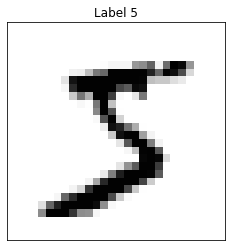

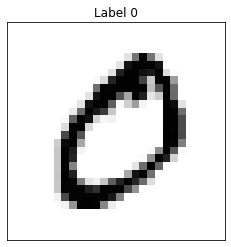

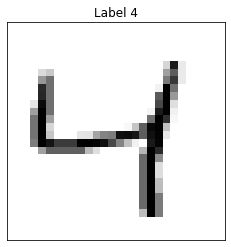

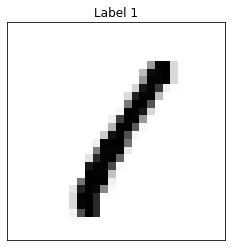

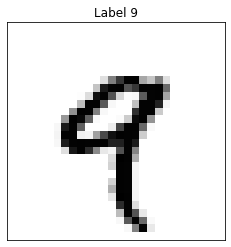

In [234]:
def visualize_image(img, label=None):
  plt.imshow(img, cmap='Greys')
  if label != None:
    plt.title(f"Label {label}")
  plt.xticks([])
  plt.yticks([])
  plt.show()


visualize_image(train_data[0], train_label[0])
visualize_image(train_data[1], train_label[1])
visualize_image(train_data[2], train_label[2])
visualize_image(train_data[3], train_label[3])
visualize_image(train_data[4], train_label[4])

# Defining some utility functions

In [31]:
def sigmoid(x):
  return 1/(1+np.e**(-x))


def elment_wise_mul(v, h, i, j):
  return v[i]*h[j]

# Defining a class representing the RBM

In [228]:
class RBM:

  def __init__(self, n_visible, n_hidden):
    self.n_hidden = n_hidden
    self.n_visible = n_visible
    self.M = np.random.randn(n_visible, n_hidden)
    self.b = np.random.randn(n_visible)
    self.c = np.random.randn(n_hidden)


  def visible_forward(self, h):
    potential = np.matmul(h, self.M.T) + self.b
    probs = sigmoid(potential)
    mask = np.random.uniform(0, 1, probs.shape)
    activations = (probs > mask).astype(np.uint8)
    return activations, probs


  def hidden_forward(self, v):
    potential = np.matmul(v, self.M) + self.c
    probs = sigmoid(potential)
    mask = np.random.uniform(0, 1, probs.shape)
    activations = (probs > mask).astype(np.uint8)
    return activations, probs


  def reconstruct(self, v):
    h, _ = self.hidden_forward(v)
    y, _ = self.visible_forward(h)
    return y


  def train(self, train_data, epochs=50, batch_size=32, lr=1):

    n = train_data.shape[0]
    iters = n // batch_size
    iters = iters if (n % batch_size == 0) else iters + 1

    train_data = train_data.reshape(n, -1)

    batch_data = [train_data[i*batch_size:(i+1)*batch_size, :] for i in range(iters)]
    
    for epoch in range(epochs):
      print(f"Training epoch {epoch+1}/{epochs}")
      with tqdm(total=iters) as pbar:
        for batch in batch_data:
          
          N = batch.shape[0]

          v_0 = batch
          h_0, _ = model.hidden_forward(v_0)
          v_1, _ = model.visible_forward(h_0)
          h_1, _ = model.hidden_forward(v_1)
          
          wake = np.einsum('ki,kj->kij', v_0, h_0)
          dream = np.einsum('ki,kj->kij', v_1, h_1)
          delta = (wake-dream).sum(axis=0)

          delta_M = (delta)/N

          self.M += delta_M*lr

          pbar.update(1)

In [206]:
model = RBM(5, 3)
v = np.random.randint(0, 2, (2,5))
a, p = model.hidden_forward(v)
print(a)

[[0 0 0]
 [0 1 1]]


In [237]:
model = RBM(784, 128)
model.train(train_data, epochs=10, batch_size=64, lr=1)

Training epoch 1/10


 13%|█▎        | 126/938 [00:07<00:41, 19.80it/s]<ipython-input-31-3dff8a4f6982>:2: RuntimeWarning: overflow encountered in power
  return 1/(1+np.e**(-x))
100%|██████████| 938/938 [00:49<00:00, 18.83it/s]


Training epoch 2/10


100%|██████████| 938/938 [00:49<00:00, 18.78it/s]


Training epoch 3/10


100%|██████████| 938/938 [00:49<00:00, 18.84it/s]


Training epoch 4/10


100%|██████████| 938/938 [00:49<00:00, 18.81it/s]


Training epoch 5/10


100%|██████████| 938/938 [00:50<00:00, 18.71it/s]


Training epoch 6/10


100%|██████████| 938/938 [00:53<00:00, 17.58it/s]


Training epoch 7/10


100%|██████████| 938/938 [00:49<00:00, 19.12it/s]


Training epoch 8/10


100%|██████████| 938/938 [00:49<00:00, 19.02it/s]


Training epoch 9/10


100%|██████████| 938/938 [00:49<00:00, 19.07it/s]


Training epoch 10/10


100%|██████████| 938/938 [00:49<00:00, 19.01it/s]


In [229]:
model = RBM(784, 128)
train_data[0].reshape(1, -1).shape

(1, 784)

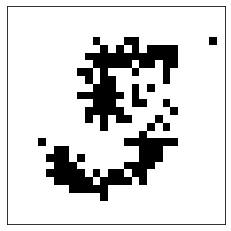

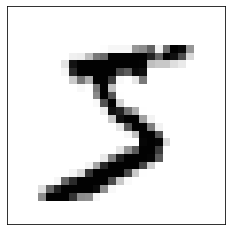

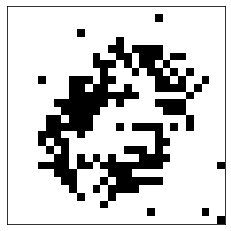

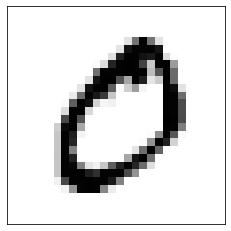

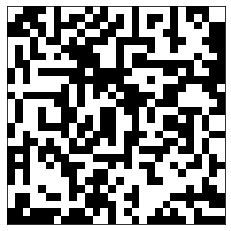

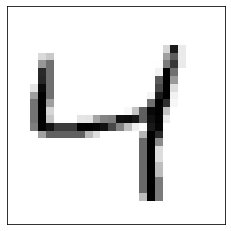

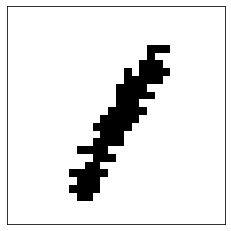

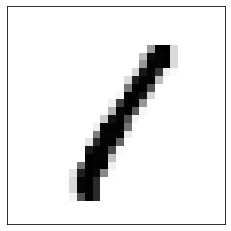

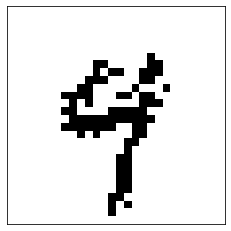

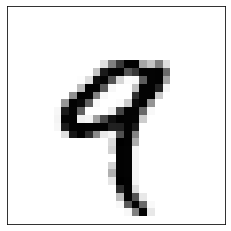

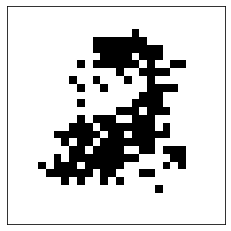

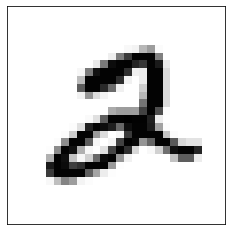

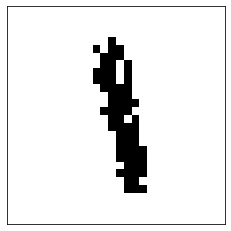

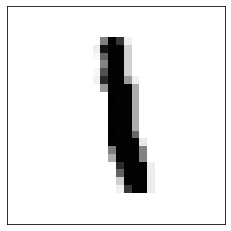

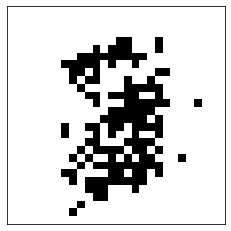

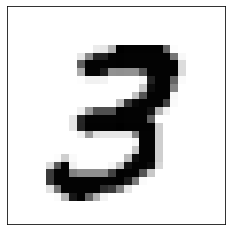

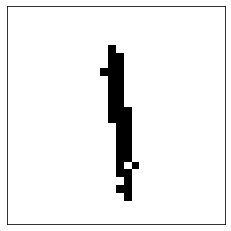

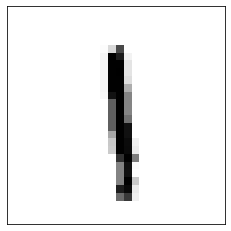

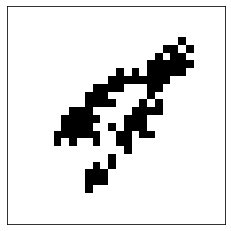

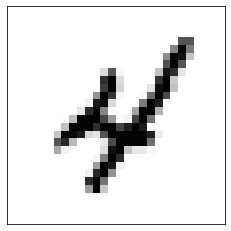

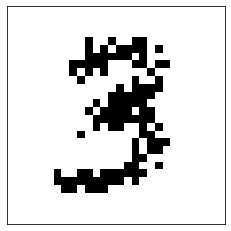

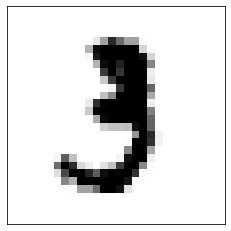

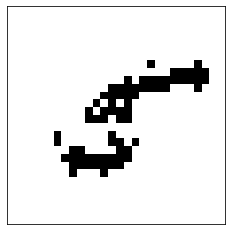

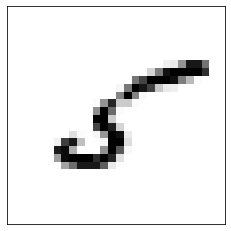

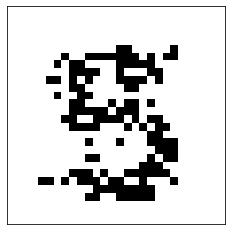

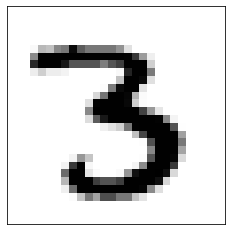

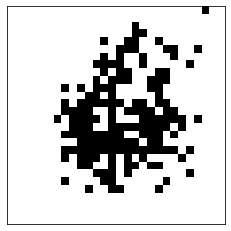

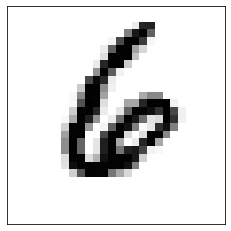

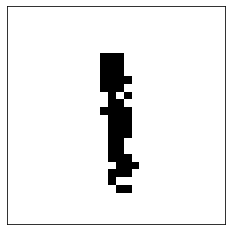

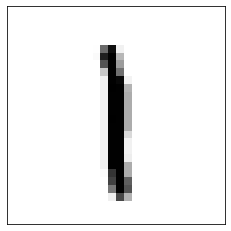

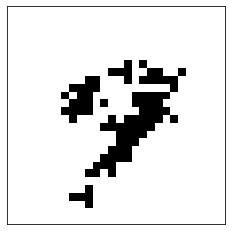

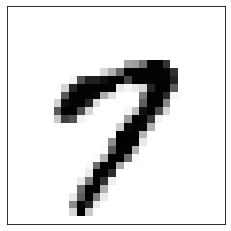

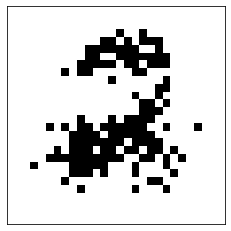

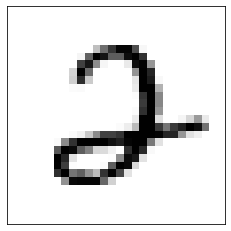

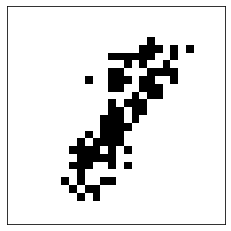

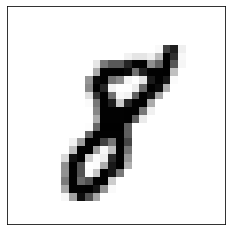

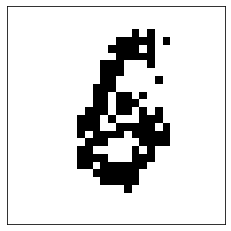

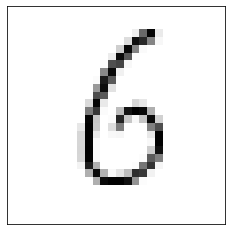

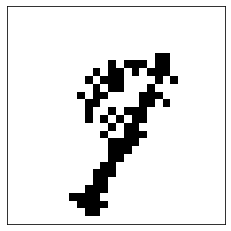

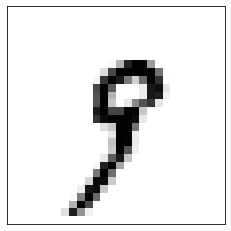

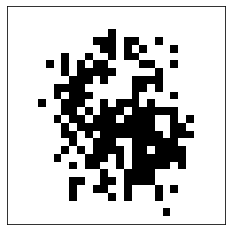

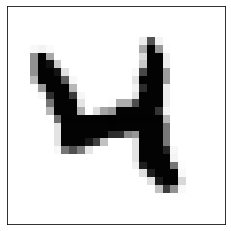

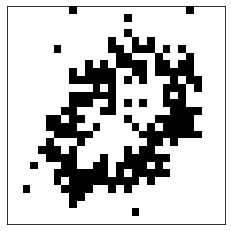

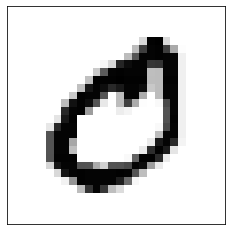

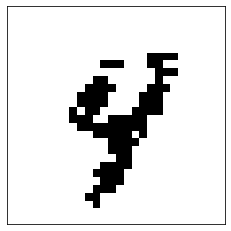

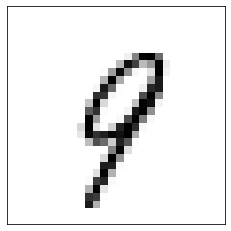

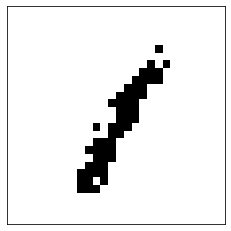

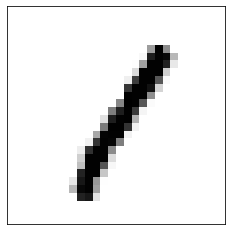

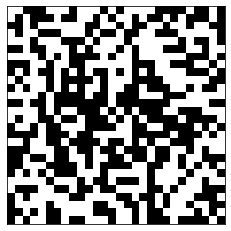

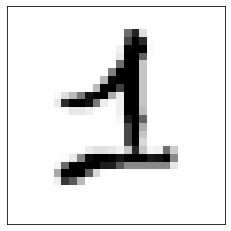

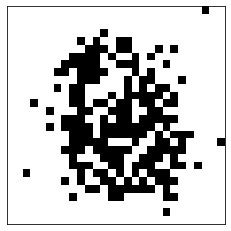

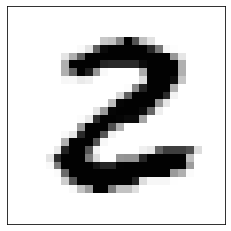

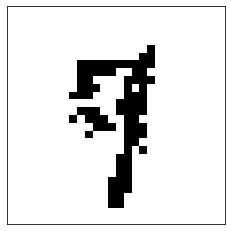

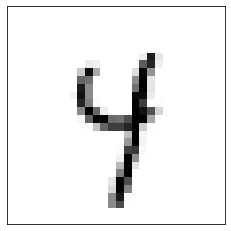

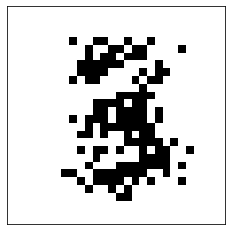

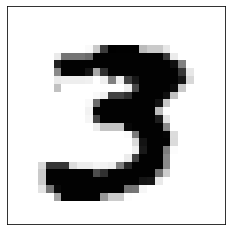

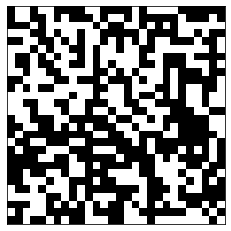

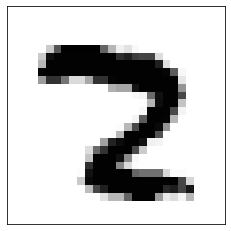

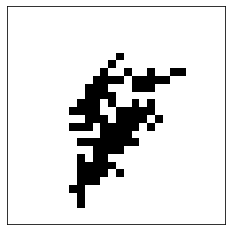

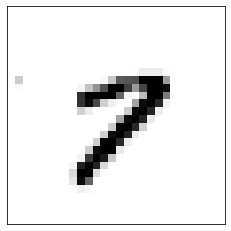

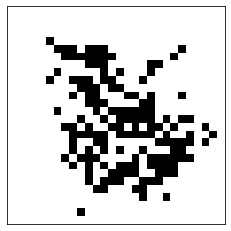

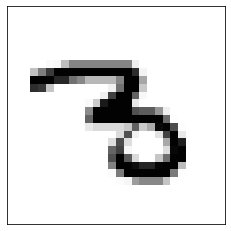

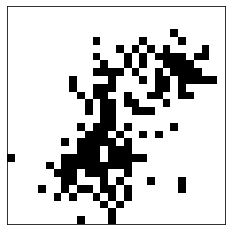

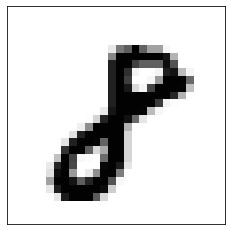

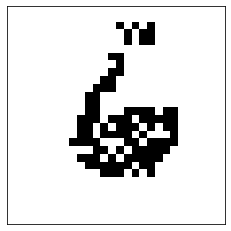

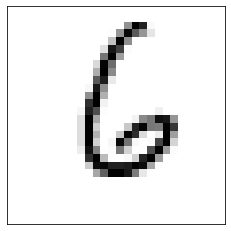

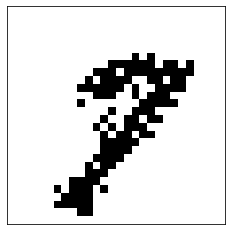

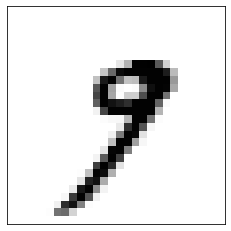

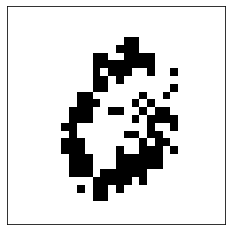

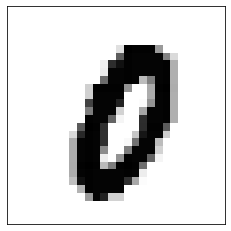

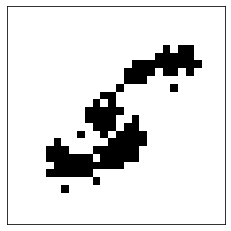

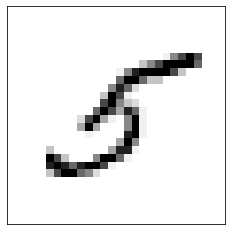

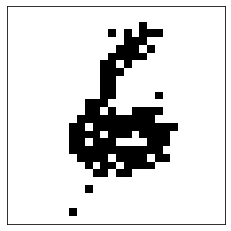

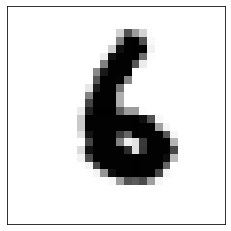

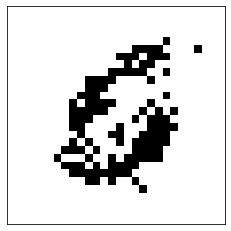

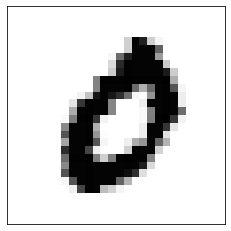

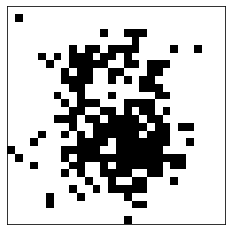

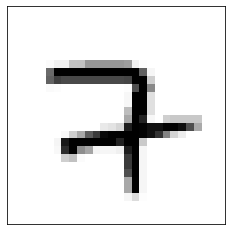

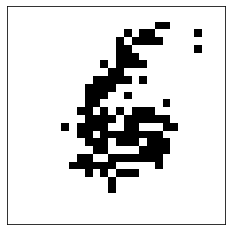

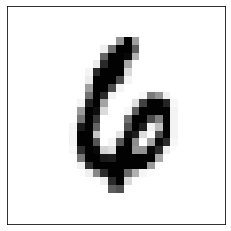

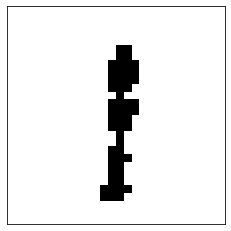

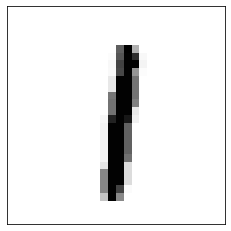

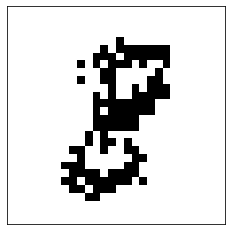

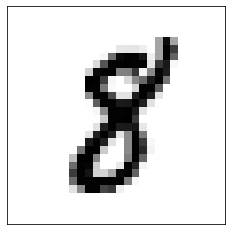

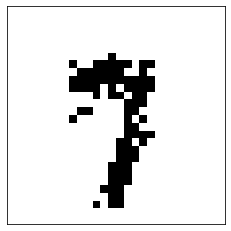

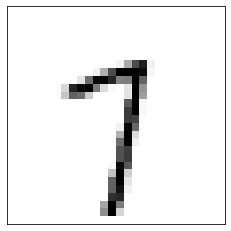

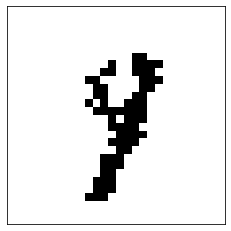

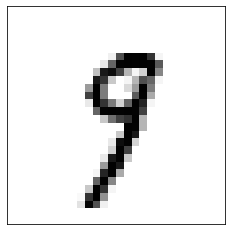

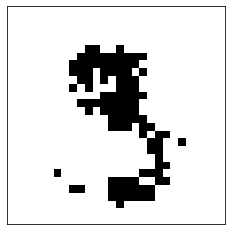

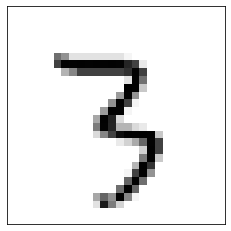

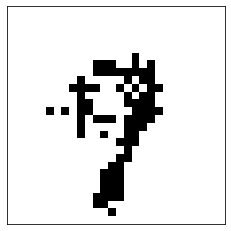

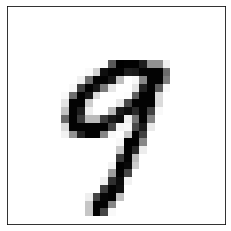

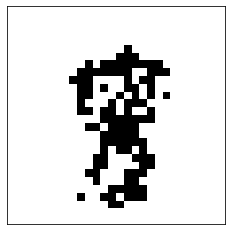

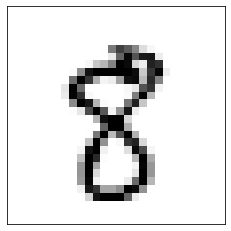

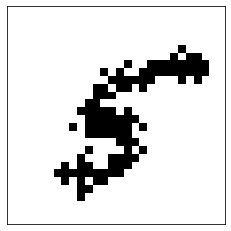

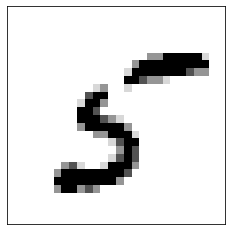

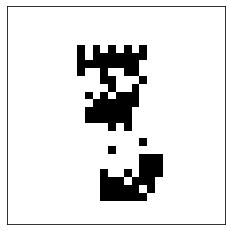

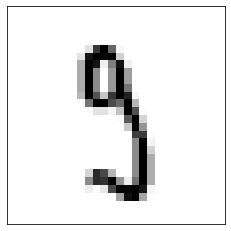

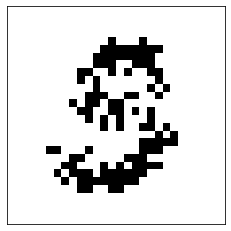

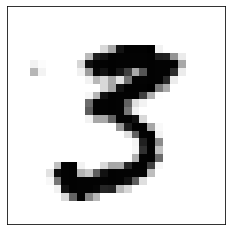

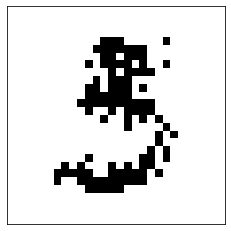

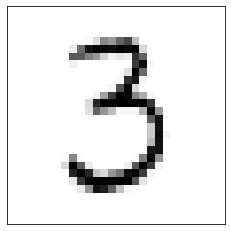

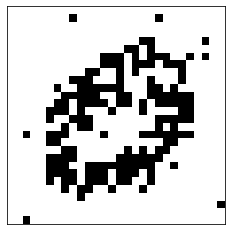

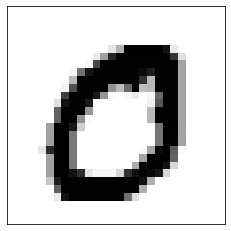

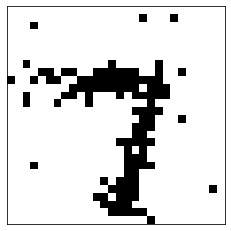

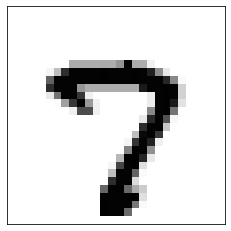

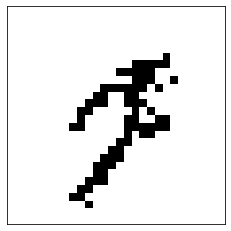

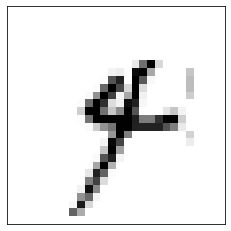

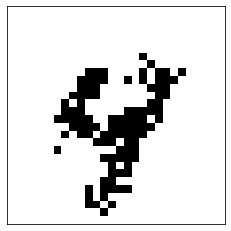

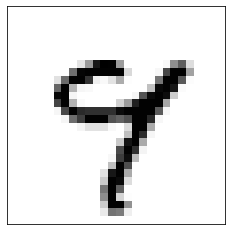

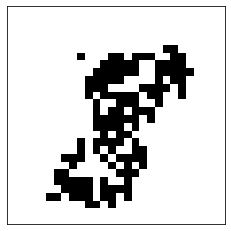

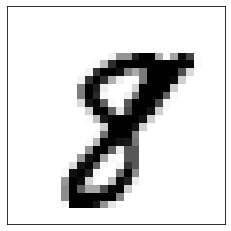

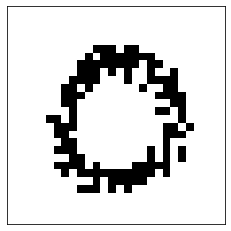

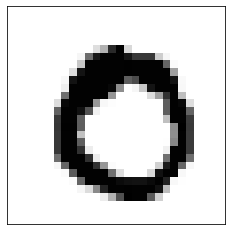

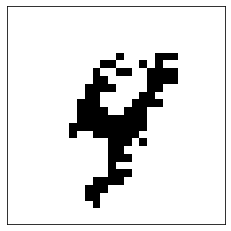

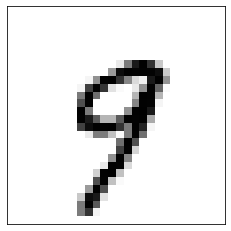

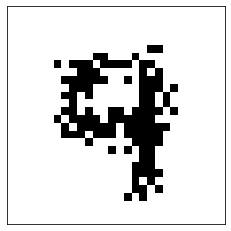

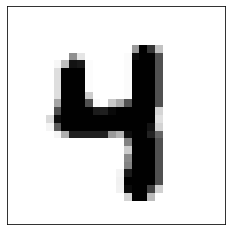

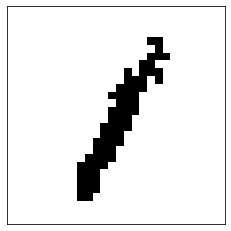

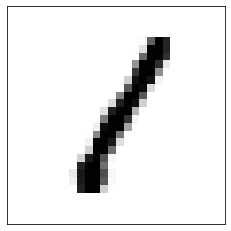

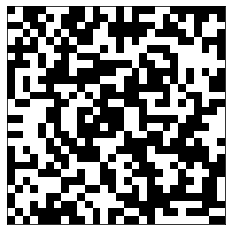

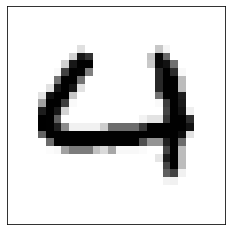

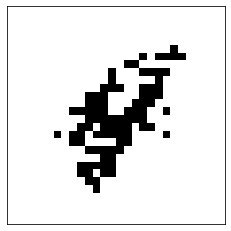

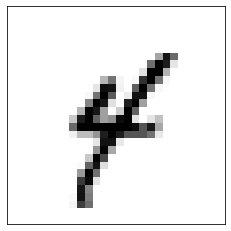

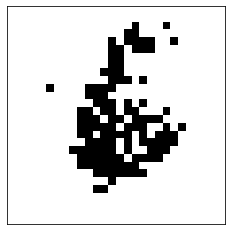

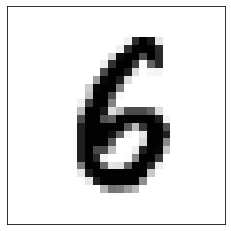

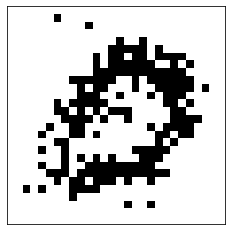

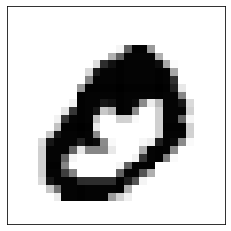

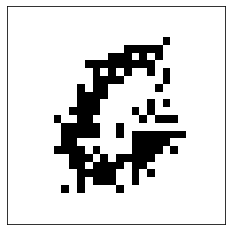

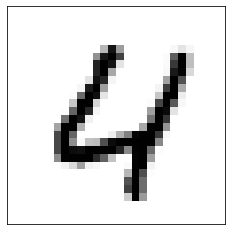

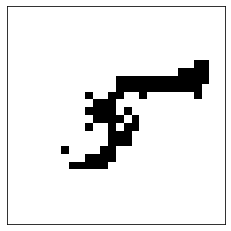

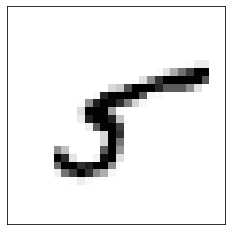

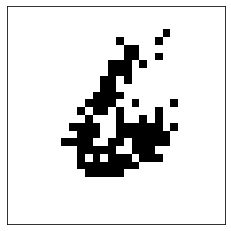

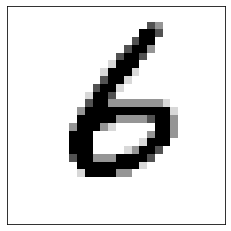

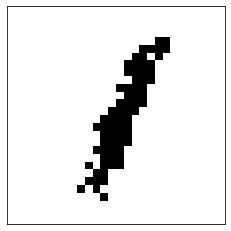

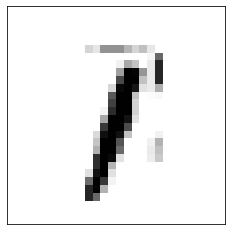

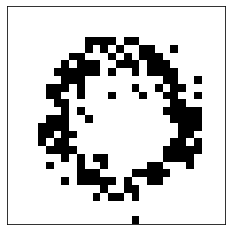

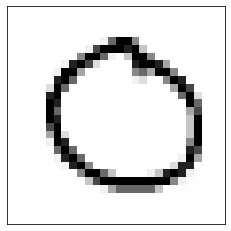

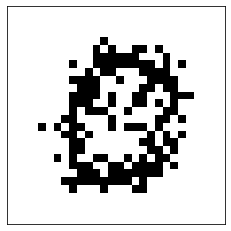

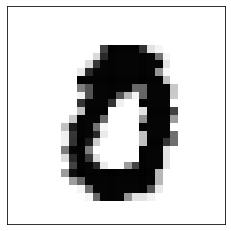

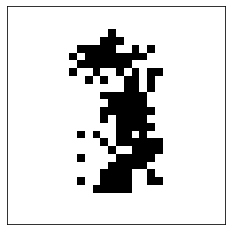

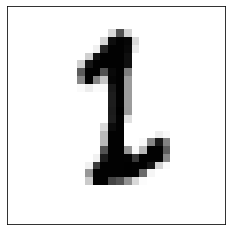

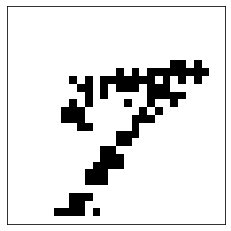

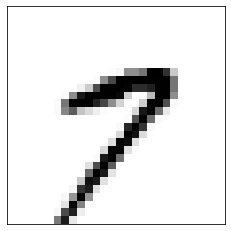

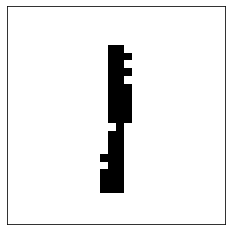

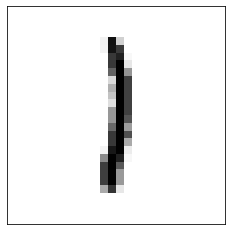

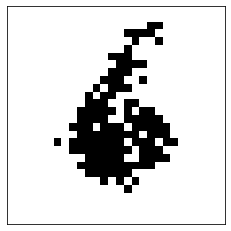

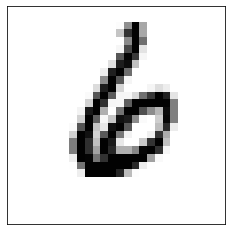

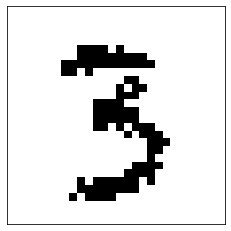

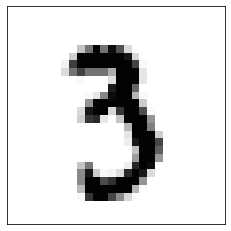

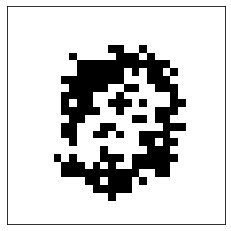

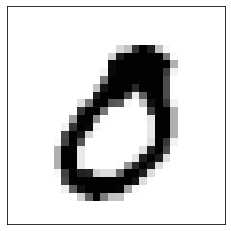

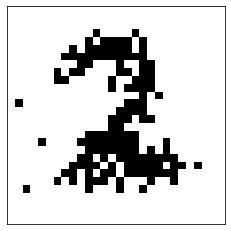

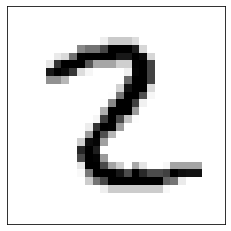

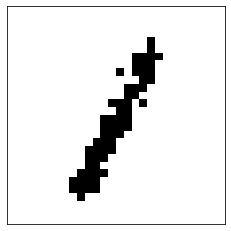

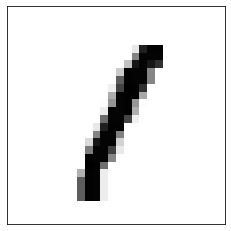

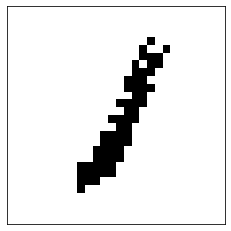

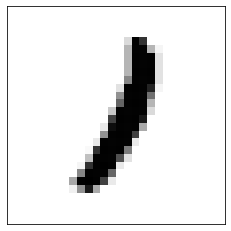

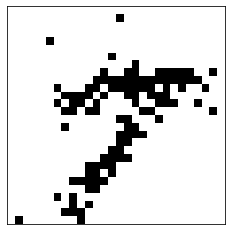

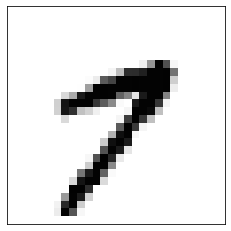

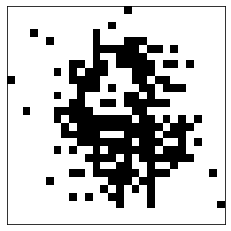

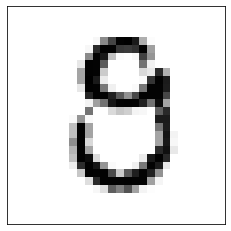

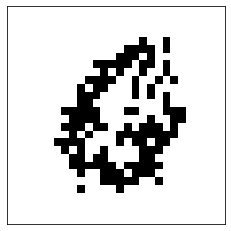

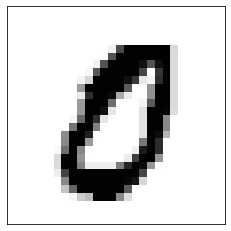

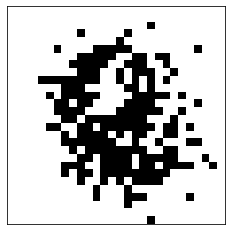

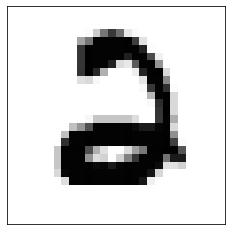

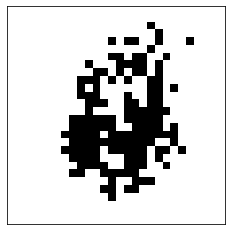

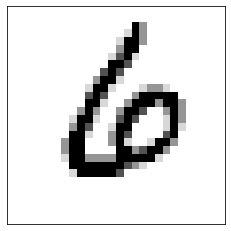

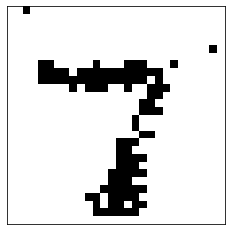

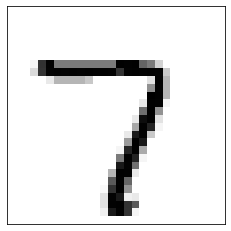

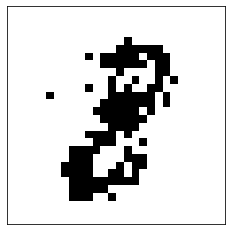

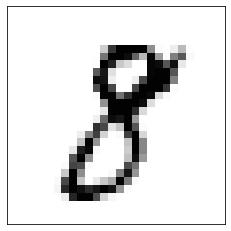

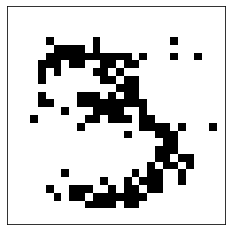

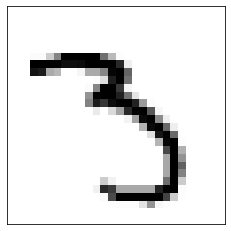

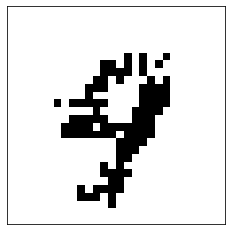

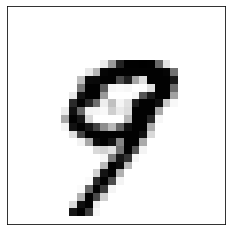

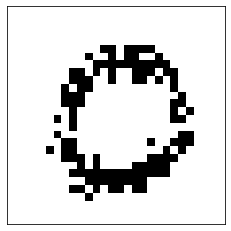

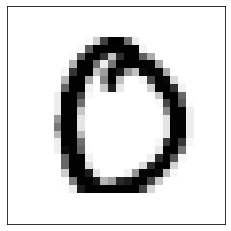

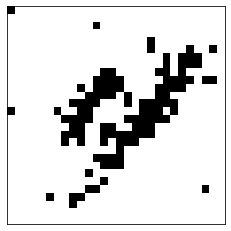

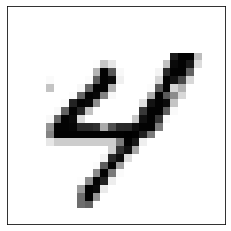

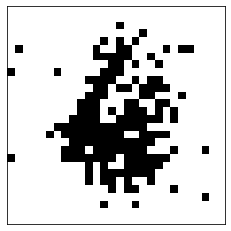

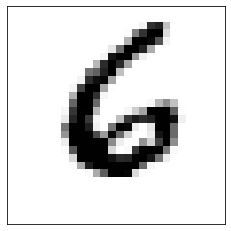

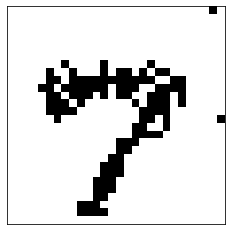

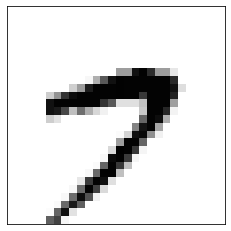

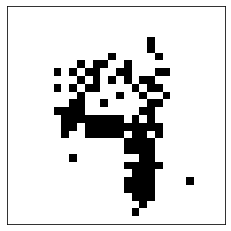

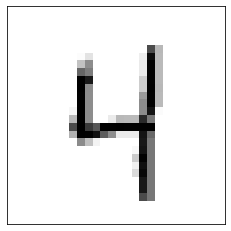

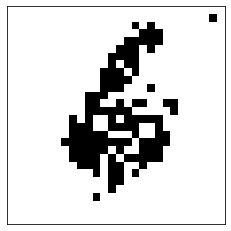

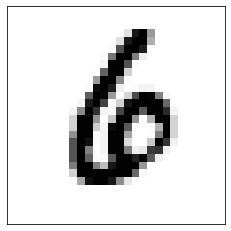

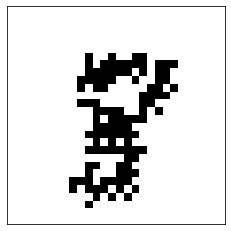

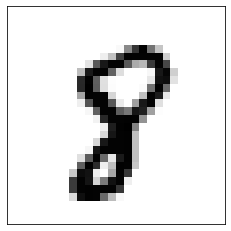

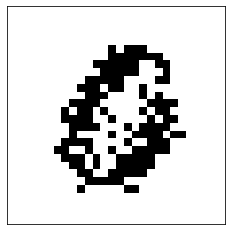

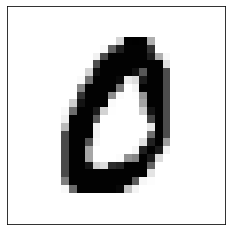

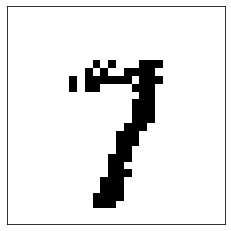

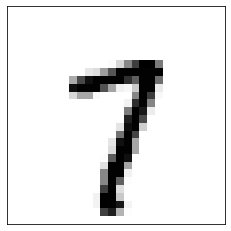

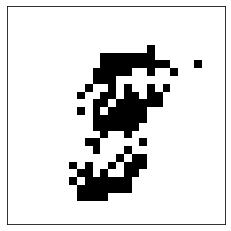

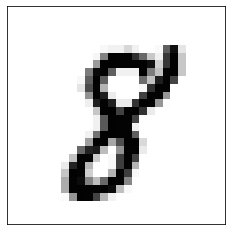

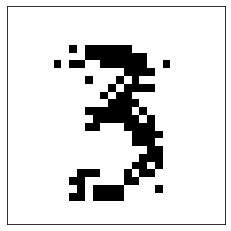

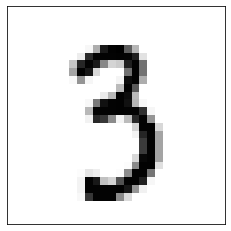

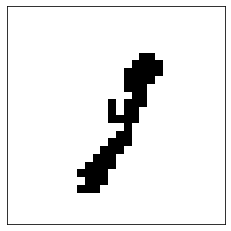

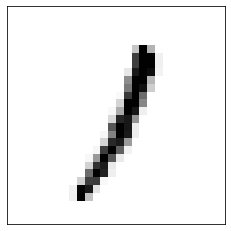

In [255]:
for idx in range(100):
  y = model.reconstruct(train_data[idx].reshape(1, -1))
  y.reshape(28, 28).shape
  visualize_image(y.reshape(28, 28))
  visualize_image(train_data[idx])
  print("============================")